In [3]:
import os
import sys
import math
import itertools
import json
import glob
from datetime import datetime
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import pandas as pd

# Add parent directory to path to find data_handling.py
# ASSUMPTION: data_handling.py is in the parent folder or current folder
sys.path.append(str(Path("..").resolve()))
from data_handling import (
    load_measurements_npz,
    load_state_npz,
    save_state_npz,
    save_measurements_npz,
    MeasurementDataset,
    MeasurementLoader,
    MultiQubitMeasurement
)

# Define and create paths
data_dir = Path("measurements")
state_dir = Path("state_vectors")
exp_dir = Path("experiments")

data_dir.mkdir(parents=True, exist_ok=True)
state_dir.mkdir(parents=True, exist_ok=True)
exp_dir.mkdir(parents=True, exist_ok=True)

print(f"Data directory:       {data_dir.resolve()}")
print(f"State directory:      {state_dir.resolve()}")
print(f"Experiment artifacts: {exp_dir.resolve()}")

# Set global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Data directory:       /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_paper/tfim_over_4x4_v2/measurements
State directory:      /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_paper/tfim_over_4x4_v2/state_vectors
Experiment artifacts: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_paper/tfim_over_4x4_v2/experiments
Running on: cpu


In [4]:
# --- GENERATION CONFIG ---
GEN_SIDE_LENGTH = 4
GEN_SAMPLES     = 50_000 # Max pool to draw from
J_VAL           = -1.00

# 1. The "Backbone" (Training Data)
h_support = [1.00, 2.00, 3.00, 4.00, 5.00, 6.00, 7.00]

# 2. The "Interpolation" (Evaluation Data)
h_novel   = [1.50, 2.50, 2.80, 3.20, 3.50, 4.50, 5.50]

# Combine for loop
all_h_values = sorted(list(set(h_support + h_novel)))

def build_tfim_hamiltonian(L, h, J):
    from netket.graph import Hypercube
    from netket.hilbert import Spin
    from netket.operator import Ising
    graph = Hypercube(length=L, n_dim=2, pbc=True)
    hilbert = Spin(s=0.5, N=graph.n_nodes)
    return Ising(hilbert, graph, h=h, J=J)

def get_groundstate(H):
    from scipy.sparse.linalg import eigsh
    sp_mat = H.to_sparse()
    evals, evecs = eigsh(sp_mat, k=1, which="SA")
    psi = evecs[:, 0]
    # Fix phase
    first_idx = np.argmax(np.abs(psi))
    phase = np.angle(psi[first_idx])
    return psi * np.exp(-1j * phase)

# --- EXECUTE GENERATION ---
# We force regeneration to fix the header structure
print("Generating Dataset with correct 'state' headers...")

rng_gen = np.random.default_rng(42)
bases = ['Z'] * (GEN_SIDE_LENGTH**2)
meas_op = MultiQubitMeasurement(bases, verbose=False)

for h in all_h_values:
    is_support = h in h_support
    print(f"Processing h={h:.2f} [{'SUPPORT' if is_support else 'NOVEL'}]")

    # 1. Solve Exact State
    H = build_tfim_hamiltonian(GEN_SIDE_LENGTH, h, J_VAL)
    psi = get_groundstate(H)

    # Save State
    sys_str = f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}"
    state_path = state_dir / f"{sys_str}_h{h:.2f}.npz"

    # --- FIX IS HERE: Header key must be 'state' ---
    header_data = {"h": h, "J": J_VAL, "system": sys_str}

    save_state_npz(state_path, psi, {"state": header_data})

    # 2. Sample (Only for Support)
    if is_support:
        samples = meas_op.sample_state(psi, num_samples=GEN_SAMPLES, rng=rng_gen)
        meas_path = data_dir / f"{sys_str}_h{h:.2f}_{GEN_SAMPLES}.npz"

        # --- FIX IS HERE: Header key must be 'state' ---
        save_measurements_npz(meas_path, samples, bases, {"state": header_data})

print("Generation Complete.")

Generating Dataset with correct 'state' headers...
Processing h=1.00 [SUPPORT]
Processing h=1.50 [NOVEL]
Processing h=2.00 [SUPPORT]
Processing h=2.50 [NOVEL]
Processing h=2.80 [NOVEL]
Processing h=3.00 [SUPPORT]
Processing h=3.20 [NOVEL]
Processing h=3.50 [NOVEL]
Processing h=4.00 [SUPPORT]
Processing h=4.50 [NOVEL]
Processing h=5.00 [SUPPORT]
Processing h=5.50 [NOVEL]
Processing h=6.00 [SUPPORT]
Processing h=7.00 [SUPPORT]
Generation Complete.


In [5]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(x, [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden], dim=-1)

class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))
        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)
        self.initialize_weights()

    def initialize_weights(self):
        nn.init.normal_(self.W, std=0.1)
        nn.init.constant_(self.b, 0.0)
        nn.init.constant_(self.c, 0.0)

    # Inside ConditionalRBM class

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        v = v.to(dtype=self.W.dtype, device=self.W.device)

        # 1. Calculate Energy of the input configuration v
        term1_v = -(v * b_mod).sum(dim=-1)
        term2_v = F.softplus(v @ self.W + c_mod).sum(dim=-1)
        fe_v = term1_v - term2_v

        # 2. Calculate Energy of the "spin-flipped" configuration (1 - v)
        # We assume binary 0/1 inputs.
        v_flipped = 1.0 - v
        term1_f = -(v_flipped * b_mod).sum(dim=-1)
        term2_f = F.softplus(v_flipped @ self.W + c_mod).sum(dim=-1)
        fe_flipped = term1_f - term2_f

        # 3. Combine them: Energy_sym = -T * log( exp(-E/T) + exp(-E_flip/T) )
        # Using LogSumExp for numerical stability
        # We stack them to apply logsumexp over the new dimension
        stacked = torch.stack([-fe_v, -fe_flipped], dim=-1)

        # The new free energy is effectively -log(P(v) + P(not v))
        # We return negative because the code expects Free Energy (Lower is better probability)
        # Note: This technically shifts the partition function Z, but gradients are correct.
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
        c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, rng: torch.Generator):
        p_h = torch.sigmoid((v @ self.W + c_mod) / self.T)
        h = torch.bernoulli(p_h, generator=rng)
        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / self.T)
        return torch.bernoulli(p_v, generator=rng)

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        # returns log(psi) = -0.5 * FE / T
        b_mod, c_mod = self._compute_effective_biases(cond)
        return -0.5 * self._free_energy(v, b_mod, c_mod) / self.T

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        v_data, _, cond = batch
        v_data = v_data.to(device=self.W.device, dtype=self.W.dtype)
        cond = cond.to(device=self.W.device, dtype=self.W.dtype)

        rng = aux_vars.get("rng")
        b_mod, c_mod = self._compute_effective_biases(cond)

        # CD-k
        v_model = v_data.clone()
        # Mix in noise
        n_noise = int(v_data.shape[0] * aux_vars.get("noise_frac", 0.5))
        if n_noise > 0:
            v_model[:n_noise] = torch.bernoulli(torch.full_like(v_model[:n_noise], 0.5), generator=rng)

        for _ in range(self.k):
            v_model = self._gibbs_step(v_model, b_mod, c_mod, rng)
        v_model = v_model.detach()

        fe_data = self._free_energy(v_data, b_mod, c_mod)
        fe_model = self._free_energy(v_model, b_mod, c_mod)
        loss = (fe_data - fe_model).mean()
        return loss, {}

    @torch.no_grad()
    def get_normalized_wavefunction(self, cond: torch.Tensor, all_states: torch.Tensor) -> torch.Tensor:
        # cond: (1, D) or (B, D)
        # all_states: (2^N, N)
        if cond.dim() == 1: cond = cond.unsqueeze(0)

        # Expand condition to match all states
        cond_exp = cond.expand(all_states.shape[0], -1)

        # Enforce T=1 for wavefunction extraction
        old_T = self.T
        self.T = 1.0
        log_psi = self.log_score(all_states, cond_exp)
        self.T = old_T

        # Normalize: sum |psi|^2 = sum exp(2*log_psi)
        log_norm_sq = torch.logsumexp(2.0 * log_psi, dim=0)
        return torch.exp(log_psi - 0.5 * log_norm_sq)

In [6]:
def get_sigmoid_curve(high, low, steps, falloff):
    center = steps / 2.0
    def fn(step):
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center))))
    return fn

def train(model, optimizer, loader, num_epochs, rng, lr_schedule_fn):
    global_step = 0
    model.train()

    # FIX: Define noise_frac here (Baseline used 0.1 or 0.05)
    training_noise_frac = 0.1

    for epoch in range(num_epochs):
        tot_loss = 0.0
        for batch in loader:
            lr = lr_schedule_fn(global_step)
            for g in optimizer.param_groups: g["lr"] = lr

            optimizer.zero_grad(set_to_none=True)

            # FIX: Pass the correct noise fraction
            loss, _ = model(batch, {"rng": rng, "noise_frac": training_noise_frac})

            loss.backward()
            optimizer.step()
            tot_loss += loss.item()
            global_step += 1

    return model

In [7]:
def generate_all_states(num_qubits: int, device: torch.device):
    lst = list(itertools.product([0, 1], repeat=num_qubits))
    return torch.tensor(lst, dtype=torch.float32, device=device)

@torch.no_grad()
def compute_overlap(model, h_val, gt_path, all_states):
    # 1. Load GT
    psi_np, _ = load_state_npz(gt_path)
    psi_true = torch.from_numpy(psi_np).real.float().to(device)
    psi_true = psi_true / torch.norm(psi_true)

    # 2. Compute Model
    cond = torch.tensor([h_val], device=device, dtype=torch.float32)
    psi_model = model.get_normalized_wavefunction(cond, all_states)

    # 3. Overlap (Linear)
    return torch.abs(torch.dot(psi_true, psi_model)).item()

In [8]:
# --- EXPERIMENT CONFIG ---
SAMPLE_SIZES = [2_000, 10_000, 50_000] # The sweep
N_EPOCHS     = 50

# Setup Evaluation Points
h_eval_support = [1.00, 2.00, 3.00, 4.00, 5.00, 6.00, 7.00]
h_eval_novel   = [1.50, 2.50, 2.80, 3.20, 3.50, 4.50, 5.50]
all_h_eval     = sorted(list(set(h_eval_support + h_eval_novel)))

# Pre-compute basis states
all_states = generate_all_states(GEN_SIDE_LENGTH**2, device)

# Setup RNG
seed = 42
torch.manual_seed(seed)
rng = torch.Generator().manual_seed(seed)

# Define file paths for loading (from Cell 2 config)
file_names = [f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}_h{h:.2f}_{GEN_SAMPLES}.npz" for h in h_support]
file_paths = [data_dir / fn for fn in file_names]

print(f"Starting experiment sweep: {SAMPLE_SIZES}")

for n_samples in SAMPLE_SIZES:
    print(f"\n>>> RUNNING: {n_samples} samples per support point <<<")

    # 1. Reload Dataset with specific limit
    ds = MeasurementDataset(file_paths, load_measurements_npz, ["h"], [n_samples]*len(file_paths))
    loader = MeasurementLoader(ds, batch_size=1024, shuffle=True, drop_last=False, rng=rng)

    # 2. Init Model
    model = ConditionalRBM(ds.num_qubits, num_hidden=16, cond_dim=1, conditioner_width=64, k=20).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = get_sigmoid_curve(1e-2, 1e-4, N_EPOCHS*len(loader), 0.005)

    # 3. Train
    model = train(model, optimizer, loader, N_EPOCHS, rng, scheduler)

    # 4. Evaluate Overlap
    results = []
    for h_val in all_h_eval:
        gt_path = state_dir / f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}_h{h_val:.2f}.npz"
        if not gt_path.exists(): continue

        ov = compute_overlap(model, h_val, gt_path, all_states)
        rtype = "support" if h_val in h_eval_support else "novel"
        results.append({"h": h_val, "overlap": ov, "type": rtype})

    # 5. Save Artifacts
    run_id = f"samples_{n_samples}"
    report = {
        "config": {"n_samples": n_samples, "epochs": N_EPOCHS},
        "results": results
    }

    with open(exp_dir / f"{run_id}_report.json", "w") as f:
        json.dump(report, f, indent=2)

    print(f"Run {run_id} complete.")

print("\nAll experiments finished.")

Starting experiment sweep: [2000, 10000, 50000]

>>> RUNNING: 2000 samples per support point <<<
Run samples_2000 complete.

>>> RUNNING: 10000 samples per support point <<<
Run samples_10000 complete.

>>> RUNNING: 50000 samples per support point <<<
Run samples_50000 complete.

All experiments finished.


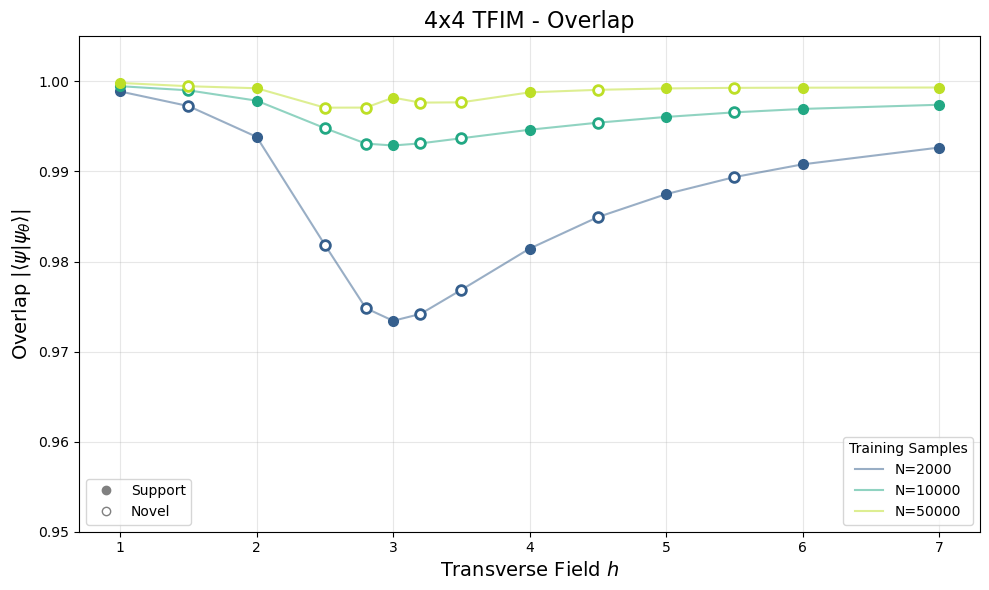

In [10]:
# Load all reports
report_files = sorted(glob.glob(str(exp_dir / "*_report.json")))
experiments = []
for fpath in report_files:
    with open(fpath, "r") as f: experiments.append(json.load(f))

# Sort by sample size
experiments.sort(key=lambda x: x["config"]["n_samples"])

plt.figure(figsize=(10, 6))
colors = cm.viridis(np.linspace(0.3, 0.9, len(experiments)))

for i, exp in enumerate(experiments):
    n = exp["config"]["n_samples"]
    df = pd.DataFrame(exp["results"])
    supp = df[df["type"] == "support"]
    nov  = df[df["type"] == "novel"]

    c = colors[i]
    # Line
    plt.plot(df["h"], df["overlap"], '-', color=c, alpha=0.5, label=f"N={n}")
    # Support
    plt.plot(supp["h"], supp["overlap"], 'o', color=c, markersize=7)
    # Novel
    plt.plot(nov["h"], nov["overlap"], 'o', color=c, markerfacecolor='white', markeredgewidth=2, markersize=7)

plt.xlabel(r"Transverse Field $h$", fontsize=14)
plt.ylabel(r"Overlap $|\langle \psi | \psi_{\theta} \rangle|$", fontsize=14)
plt.title(f"{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH} TFIM - Overlap", fontsize=16)

# Legends
color_leg = plt.legend(loc='lower right', title="Training Samples")
plt.gca().add_artist(color_leg)

custom_lines = [
    Line2D([0], [0], color='gray', marker='o', linestyle='None', label='Support'),
    Line2D([0], [0], color='gray', marker='o', markerfacecolor='white', linestyle='None', label='Novel')
]
plt.legend(handles=custom_lines, loc='lower left')

plt.ylim(0.95, 1.005)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()